# Predict the nationality a name belongs to

In [1]:
from io import open
import os, string, random, time, math
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from sklearn.model_selection import train_test_split

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

In [4]:
from IPython.display import clear_output # clears output of cell, say to show multiple plots but show only most recent one

# Dataset

Task : Sequence Classification

In [6]:
languages = []
data = []
X = []
y = []

with open('name2lang.txt','r') as f:
  for line in f:
    line = line.split(',')
    name = line[0].strip()
    lang = line[1].strip()
    if not lang in languages:
      languages.append(lang)
    X.append(name)
    y.append(lang)
    data.append((name, lang))

In [7]:
n_languages = len(languages)
print(n_languages)

18


There are 18 languages in this dataset.

In [8]:
print(languages)

['Portuguese', 'Irish', 'Spanish', 'Vietnamese', 'Chinese', 'Greek', 'Czech', 'Dutch', 'Japanese', 'French', 'German', 'Scottish', 'English', 'Russian', 'Polish', 'Arabic', 'Korean', 'Italian']


In [9]:
print(data[0:10])

[('Abreu', 'Portuguese'), ('Albuquerque', 'Portuguese'), ('Almeida', 'Portuguese'), ('Alves', 'Portuguese'), ('Araujo', 'Portuguese'), ('Araullo', 'Portuguese'), ('Barros', 'Portuguese'), ('Basurto', 'Portuguese'), ('Belo', 'Portuguese'), ('Cabral', 'Portuguese')]


# Train-test split

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 61, stratify = y)

(Both X and y should have the same dimensions)

In [11]:
print(X_train[:20])

['Kaufman', 'Chandler', 'Agar', 'Essa', 'Makhagonov', 'Prokudin', 'Porus', 'Lowry', 'Nezvigin', 'Cove', 'Peach', 'Newlands', 'Bajov', 'Chukhnovsky', 'Naser', 'Gaspirovich', 'Vykhodtsev', 'Chuvilkin', 'Maksimchuk', 'Dandy']


In [12]:
print(len(X_train), len(X_test))

16040 4010


# Encoding names and languages

Since output is a class, can use just nationality number (label) for encoding.  
But input is a sequence, so have to encode each character using one hot encoding.

In [13]:
# list of all characters possible in a name
all_letters = string.ascii_letters + " .,;"
n_letters = len(all_letters)

Encode the name

In [14]:
# Let encoding be one hot encoding for each character, where the hot bit is the index of the char in the above string of all letters
def name_rep(name):
  rep = torch.zeros(len(name), 1, n_letters)
  for index, letter in enumerate(name):
    pos = all_letters.find(letter)
    rep[index][0][pos] = 1
  return rep

Encode the language

In [15]:
# Don't require one hot encoding, just label sufficient
def lang_rep(lang):
  return torch.tensor([languages.index(lang)], dtype = torch.long)

In [16]:
name_rep('Almeida')

tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0.]],

        [[0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0

7 letters in name, so 7 vectors

In [17]:
lang_rep('Dutch')

tensor([7])

Label of Dutch in languages array

# Basic Visualisation

Distribution of languages in our dataset

In [18]:
count = {}

for l in languages:
  count[l] = 0
for d in data:
  count[d[1]] += 1

In [19]:
print(count)

{'Portuguese': 74, 'Irish': 232, 'Spanish': 298, 'Vietnamese': 73, 'Chinese': 268, 'Greek': 203, 'Czech': 519, 'Dutch': 297, 'Japanese': 991, 'French': 277, 'German': 724, 'Scottish': 100, 'English': 3668, 'Russian': 9384, 'Polish': 139, 'Arabic': 2000, 'Korean': 94, 'Italian': 709}


Highly non-uniform

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


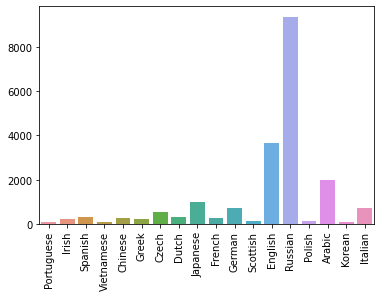

In [20]:
plt_ = sns.barplot(list(count.keys()), list(count.values()))
plt_.set_xticklabels(plt_.get_xticklabels(), rotation = 90)
plt.show()

Model might learn Russian names too well and predict them well since lots of data, but less training on the rest (available data mostly has Russians).  
Hence, have to see not the overall accuracy, but accuracy for each language.

Therefore, baseline is not to pick names from each language equally, but pick according to the distribution, more for Russian.

Thus, baseline testing is easy, but training isn't

# Basic network and testing inference

In [21]:
class RNN_net(nn.Module):
  # just setting up layers, not computing anything
  # input_size : size of encoding of one character in the input (i.e. number of letters, here)
  # hidden_size : the hidden layer though looks like one (for a single unit of the RNN) can be any number of layers
  # output_size : the number of labels (number of languages, here)

  # the entire below thing forms one unit of the RNN
  def __init__(self, input_size, hidden_size, output_size):
    super(RNN_net, self).__init__() # parent's (NN's) init
    self.hidden_size = hidden_size

    # both below are Linear (fully connected)
    self.i2h = nn.Linear(input_size + hidden_size, hidden_size) 
    self.i2o = nn.Linear(input_size + hidden_size, output_size)

    # Note only 1 layer used for both above transformations, but can have more
    
    # Output (for sequence classification, this softmax layer's output is ignored for all stages except the final one)
    self.softmax = nn.LogSoftmax(dim = 1)


  # where layers are put to use
  def forward(self, input_, hidden):
    combined = torch.cat((input_, hidden), 1)
    hidden = self.i2h(combined) # compute hidden value (state)
    output = self.i2o(combined) # compute output (not used anywhere except in final stage for this task)
    output = self.softmax(output) # compute softmax
    return output, hidden # return both output and hidden

  # the first time (beginning of sequence) the hidden vector is not present, so call this function the first time
  def init_hidden(self):
    return torch.zeros(1, self.hidden_size) # Randomly initialised to 1, can use something else too

Now, instantiate model (hyperparameters)

In [22]:
# number of hidden layers
n_hidden = 128 # compromise between overfitting and having less data

In [23]:
net = RNN_net(n_letters, n_hidden, n_languages)

Now, unlike CNNs, infer before testing.

In [24]:
def infer(net, name):
  net.eval() # put network in eval mode during inference (not train mode - where training happens)
  name_ohe = name_rep(name) # one hot encoding
  hidden = net.init_hidden() # initialise hidden vector for first instance of RNN, using encapsulated function

  # name_ohe dimensions = (n_letters, 1, sizeofword)
  # here, iterating through each character. For each character in OHE, invoking forward ("net")
  for i in range(name_ohe.size()[0]):
    
    output, hidden = net(name_ohe[i], hidden)

  return output

While inferring, an optimisation could be done, by removing softmax layer in the "forward" function of the model, since argmax will remain same before and after an argmax. It's only a computationally heavy operation.

In [25]:
output = infer(net, X_train[0]) # distribution over all classes (nationalities)

print(X_train[0])

# Softmax returned so argmax
index = torch.argmax(output)
print(output)
print(index)

Kaufman
tensor([[-2.7809, -2.8248, -2.9207, -2.8739, -2.9530, -2.9320, -2.9066, -2.9185,
         -2.8253, -2.8201, -2.8141, -2.8730, -2.9641, -2.8456, -2.9336, -2.9093,
         -3.0372, -2.9299]], grad_fn=<LogSoftmaxBackward>)
tensor(0)


Says Kaufman belongs to nationality of index 0 i.e. Portuguese.  
Note: without training, probabilities of all classes are roughly same.

# Evaluate model

In [26]:
# just to generate random inputs from the dataset since in the data, languages are present in an ordered manner
def dataloader(npoints, X_, y_):
  to_ret = []
  for i in range(npoints):
    index_ = np.random.randint(len(X_))
    name, lang = X_[index_], y_[index_]
    to_ret.append((name, lang, name_rep(name), lang_rep(lang))) # append() takes exactly one argument so append as tuple
  return to_ret

In [27]:
dataloader(2, X_train, y_train)

[('Nurov',
  'Russian',
  tensor([[[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
            0., 0., 0., 0., 0.]],
  
          [[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
            0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

Output: Name, lang, name_enc, lang_enc

In [28]:
# Generally classification eval done using top-k accuracy (ground truth in top-k predictions)
def eval(net, n_points, k, X_, y_):

  data_ = dataloader(n_points, X_, y)
  correct = 0

  for name, language, name_ohe, lang_rep in data_:

    output = infer(net, name)
    val, indices = output.topk(k) # topk - PyTorch function

    if lang_rep in indices:
      correct +=1

  accuracy = correct/n_points
  return accuracy

In [29]:
eval(net, 100, 1, X_test, y_test)

0.09

In [30]:
eval(net, 100, 10, X_test, y_test)

0.58

Obviously greater for higher k since almost all languages predicted

# Training

### Basic setup
(for just one batch)

Define loss function and backpropagation  


In [31]:
def train(net, opt, criterion, n_points): # criterion = loss function

  # set all params to 0, in case they were retained from an earlier training
  opt.zero_grad()
  total_loss = 0

  # choose random points
  data_ = dataloader(n_points, X_train, y_train)

  for name, language, name_ohe, lang_rep in data_:

    hidden = net.init_hidden()

    # pass each character
    # creating computational graph (i.e. the params, output for each individual unit of the RNN - all being stored by PyTorch). While backpropagating, we backpropagate through all of these
    for i in range(name_ohe.size()[0]):
      output, hidden = net(name_ohe[i], hidden)

    loss = criterion(output, lang_rep)

    # computing gradients
    loss.backward(retain_graph = True)

    total_loss += loss

  # update params using the grad computed using loss.backward 
  # Just one step here
  opt.step()

  # divide since we aggregated loss for all points
  return total_loss/n_points

The above is for one batch of n_points. For all these points, computing one set of gradients and updating only once.

In [32]:
criterion = nn.NLLLoss() # negative log likelihood loss because using softmax
opt = optim.SGD(net.parameters(), lr = 0.01, momentum = 0.9)

Loss: Negative Log Likelihood    
Strategy: Stochastic Gradient Descent
Optimizer: Vanilla (Optionally if you mention nesterov=True, it'll use NAG)   
Activation function: tanh (RNN uses sigmoid(mostly)/tanh(mostly)/relu)   
https://pytorch.org/docs/stable/generated/torch.nn.RNN.html   
Regularisation: Not used here (can pass L2 to optim.SGD)

In [33]:
%%time
train(net, opt, criterion, 200)

CPU times: user 327 ms, sys: 30.1 ms, total: 357 ms
Wall time: 399 ms


tensor(2.8942, grad_fn=<DivBackward0>)

In [34]:
# Top-1
eval(net, 1000, 1, X_test, y_test)

0.0

### Full training setup

1 function to train just a batch  
1 cell to encapsulate all the hyperparameters (optimizer etc)  
1 function for the training setup (which takes all hyperparameters as arguments) - this function doesn't contain all details - just ML flow with parameters.

In [35]:
def train_setup(net, lr = 0.01, n_batches = 100, batch_size = 10, momentum = 0.9, display_freq = 5):
  # display every 5 iterations

  criterion = nn.NLLLoss()
  # Note: If last function is softmax in model, then HAVE to use NLLLoss, else if softmax not mentioned, can use Cross Entropy Loss Function
  # As mentioned earlier, don't have to use softmax since it is computationally heavy, and all we need is the top-k. But required when inferring. So can use softmax.
  
  opt = optim.SGD(net.parameters(), lr = lr, momentum = momentum)

  loss_arr = np.zeros(n_batches + 1)

  for i in range(n_batches):
    # call to 'train' for each batch
    loss_arr[i+1] = (loss_arr[i]*i + train(net, opt, criterion, batch_size))/(i+1)

    if i%display_freq == display_freq-1:
      clear_output(wait=True)

      print("Iteration",i,"Top-1", eval(net, len(X_test), 1, X_test, y_test), "Top-2", eval(net, len(X_test), 1, X_test, y_test))

      plt.figure()
      plt.plot(loss_arr[1:i], '-*')
      plt.xlabel('Iteration')
      plt.ylabel('Loss')
      plt.show()
      print("\n\n")
      

Iteration 99 Top-1 0.014214463840399002 Top-2 0.013466334164588529


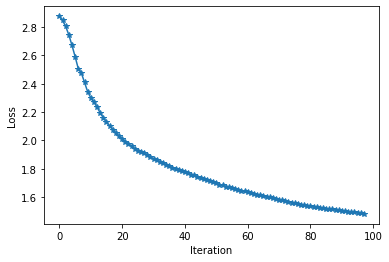

In [36]:
n_hidden = 128
net = RNN_net(n_letters, n_hidden, n_languages)
train_setup(net, lr = 0.0005, n_batches = 100, batch_size = 256)

In [38]:
eval(net, 100, 10, X_test, y_test)

0.67

Higher accuracy

In [39]:
output = infer(net, X_train[0]) # distribution over all classes (nationalities)

print(X_train[0])

# Softmax returned so argmax
index = torch.argmax(output)
print(output)
print(index)

Kaufman
tensor([[-5.1452, -3.7648, -4.1480, -5.2327, -3.9522, -4.6297, -3.3372, -4.4717,
         -3.3902, -3.9819, -3.9470, -4.8835, -1.6475, -0.9819, -4.6259, -1.6100,
         -5.0749, -4.4541]], grad_fn=<LogSoftmaxBackward>)
tensor(13)


This time predicts that Kaufman belongs to nationality with index 13 i.e. Russian. (Previously, before training had predicted as English).  

Also note that this time the probabilities of all classes are not similar (as it was before the training).

In [42]:
for x in data:
  if(x[0]=="Kaufman"):
    print(x[0], "actually belongs to", x[1])

Kaufman actually belongs to German
Kaufman actually belongs to English
Kaufman actually belongs to Russian


Thus, our prediction is right!

Try another name:

In [49]:
output = infer(net, "Almeida") 

print("Almeida")

index = torch.argmax(output)
print(output)
print(index)

Almeida
tensor([[-4.6645, -3.7132, -3.2017, -5.1106, -4.9557, -4.4624, -2.3904, -3.8962,
         -1.0801, -3.1977, -3.0970, -4.7261, -2.3989, -2.6710, -3.9286, -3.7728,
         -5.2605, -1.9196]], grad_fn=<LogSoftmaxBackward>)
tensor(8)


In [50]:
for x in data:
  if(x[0]=="Almeida"):
    print(x[0], "actually belongs to", x[1])

Almeida actually belongs to Portuguese


The prediction was that the name Almeida belongs to "Japanese". However, the name actually belongs to "Portuguese" nationality. The wrong prediction makes sense, since the data present for all nationalities except Russian and English is way too less than those present for the 2 classes.

# LSTM Cell

In [51]:
class LSTM_net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(LSTM_net, self).__init__()
    self.hidden_size = hidden_size
    self.lstm_cell = nn.LSTM(input_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size) # one linear (fully connected) layer, that computes the output (number of languages) from the hidden layer
    self.softmax = nn.LogSoftmax(dim=2)

  def forward(self, input_, hidden):
    # .view => reshape. -1 => flatten out whatever's remaining
    # (can give several inputs simultanously (to benefit from vectorization, but not done here), number of batches, to flatten)
    out, hidden = self.lstm_cell(input_.view(1, 1, -1), hidden)
    output = self.h2o(hidden[0])
    output = self.softmax(output)
    return output.view(1, -1), hidden # flatten

  # this time 2 tuples since - one for hidden state, and other for cell state
  def init_hidden(self):
    # (1, 1, self.hidden_size) -> (number of layers in LSTM cell, number of batches, size)
    return (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

Iteration 99 Top-1 0.0 Top-2 0.0


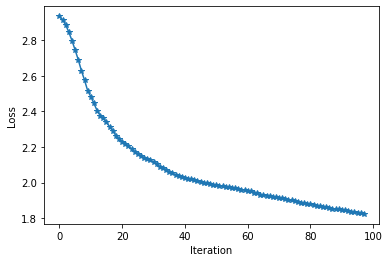

In [52]:
n_hidden = 128
net = LSTM_net(n_letters, n_hidden, n_languages)
train_setup(net, lr = 0.0005, n_batches = 100, batch_size = 256)

In [53]:
eval(net, 100, 10, X_test, y_test)

0.7

In [54]:
output = infer(net, X_train[0]) 

print(X_train[0])

index = torch.argmax(output)
print(output)
print(index)

Kaufman
tensor([[-5.2038, -4.3055, -4.3255, -5.4446, -4.2765, -4.4077, -3.5965, -4.0659,
         -2.8488, -4.0753, -3.1009, -5.0598, -1.4983, -0.9289, -4.8432, -2.4323,
         -5.1774, -3.0641]], grad_fn=<ViewBackward>)
tensor(13)


Predicts correctly that the name Kaufman belongs to "Russian" nationality.

In [55]:
output = infer(net, "Almeida")

print("Almeida")

index = torch.argmax(output)
print(output)
print(index)

Almeida
tensor([[-4.8258, -3.9908, -4.0081, -5.0777, -3.9239, -4.0200, -3.2581, -3.7622,
         -2.3309, -3.7414, -2.7473, -4.6841, -1.3054, -2.0082, -4.4767, -1.8039,
         -4.8561, -2.7136]], grad_fn=<ViewBackward>)
tensor(12)


Like RNN, gives the wrong prediction. The name Almeida belongs to Portuguese, but is classified as English. 

Again this makes sense since most of the data available for Russian and English nationality.

# GRU Cell

Fewer number of gates.  

In [66]:
class GRU_net(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(GRU_net, self).__init__()
    self.hidden_size = hidden_size
    self.gru_cell = nn.GRU(input_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.softmax = nn.LogSoftmax(dim=2)

  def forward(self, input_, hidden):
    out, hidden = self.gru_cell(input_.view(1, 1, -1), hidden)
    output = self.h2o(hidden[0])
    output = self.softmax(output)
    return output.view(1, -1), hidden

  def init_hidden(self):
    return torch.zeros(1, 1, self.hidden_size)

In [ ]:
n_hidden = 128
net = GRU_net(n_letters, n_hidden, n_languages)
train_setup(net, lr = 0.0005, n_batches = 100, batch_size = 128)